In [1]:
%load_ext autoreload
%autoreload 2

import json
import math
import random
import sys
sys.path.append('../')

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
# genff imports
from genff.data_handling.dataset import GroupDataset
from genff.data_handling.transform import RectangularAngle
from genff.eval.gen_fun import gen_yang
from genff.gan_method.networks import GenNet
from genff.mode_estimation.mode_estimation import find_modes
from genff.opt_method.opt_generator import opt_generator, opt_generator_loss, torch_to_numpy
from genff.visualization.plotting import convert_to_rect_representation

In [3]:
def load_args(path):
    # save params
    with open(path, 'r') as fid:
        return json.load(fid)
    

def load_generator(model_folder: str, pt_name: str) -> torch.nn.Module:
    model_path = "../wgan_models/{}/{}".format(model_folder,pt_name)
    args_path = "../wgan_models/{}/args.txt".format(model_folder)
    args = load_args(args_path)
    generator = GenNet(args["grid_res"], int(args["grid_w"]), int(args["grid_w"]), bool(args["combine_env_channels"]), sigma=args["plot_sigma"])
    print(args)
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    generator.load_state_dict(checkpoint['generator_state_dict'])
    return generator

# Plotting the environment and context

In [4]:
def env_cropped_grey(env_cropped, eres=0.25):
    offset_x = (env_cropped.shape[1] * 0.5) * eres
    offset_y = (env_cropped.shape[0] * 0.5) * eres
    
    env_np = np.zeros((24,24,3))
    
    env_np[:,:,0] = np.where(env_cropped[:,:,1].detach().numpy() > 0.0, np.ones((24,24)), np.zeros((24,24)))
    env_np[:,:,1] = np.where(env_cropped[:,:,3].detach().numpy() > 0.0, np.ones((24,24)), np.zeros((24,24)))
    env_np[:,:,2] = np.where(env_cropped[:,:,2].detach().numpy() > 0.0, np.ones((24,24)), np.zeros((24,24)))
    
    grayscale_img = np.dot(env_np, [1.0, 2.0, 4.0]) # free, short, tall
    grayscale_img = np.where(grayscale_img == 7.0, np.ones((24,24))*2.0,grayscale_img) # free, short and tall => short
    grayscale_img = np.where(grayscale_img == 6.0, np.ones((24,24))*2.0,grayscale_img) # short and tall => short
    grayscale_img = np.where(grayscale_img == 5.0, np.ones((24,24)),grayscale_img) # free and tall => free
    grayscale_img = np.where(grayscale_img == 3.0, np.ones((24,24))*2.0,grayscale_img) # free and short => short

    grayscale_img = np.where(grayscale_img == 1.0, np.ones((24,24))*0.92,grayscale_img) # free is lightest grey
    grayscale_img = np.where(grayscale_img == 2.0, np.ones((24,24))*0.75,grayscale_img) # short is light grey
    grayscale_img = np.where(grayscale_img == 4.0, np.ones((24,24))*0.58,grayscale_img) # tall is dark grey
    grayscale_img = np.where(grayscale_img == 0.0, np.ones((24,24))*0.41,grayscale_img) # unknown is darkest grey
    
    return grayscale_img, offset_x, offset_y


# get individual tensor
def make_rect_tensor(input_np):
    input_tensor = torch.from_numpy(input_np)
    out_tensor = torch.zeros((input_tensor.shape[0],4))
    out_tensor[:,0:2] = input_tensor[:,0:2]
    out_tensor[:,2] = torch.cos(input_tensor[:,2])
    out_tensor[:,3] = torch.sin(input_tensor[:,2])
    return out_tensor


# function to get a distribution of samples from a WGAN model
def generate_distribution_gan(generator, rect_context, rect_mask, rect_env, mode_samples=36):
    generator.eval()
    
    with torch.no_grad():
        dist_samples = []
        
        for sample in range(mode_samples):
            out = generator(rect_context, rect_mask, rect_env)
            dist_samples.append(out)
            
        dist_tensor = torch.cat(dist_samples)
        dist_samples = np.zeros((mode_samples,3))
        dist_np = dist_tensor.squeeze(1).numpy()
        dist_samples[:,0:2] = dist_np[:,0:2]
        dist_samples[:,2] = np.arctan2(dist_np[:,3], dist_np[:,2])
        return dist_samples

In [5]:
# get sample from dataset
test_dataset = GroupDataset('../data/cocktail_party/cocktail_party_test.h5')
transform = RectangularAngle(angle_index=2)

x = np.arange(-3, 3, 1.0)
y = np.arange(-3, 3, 1.0)
xv, yv = np.meshgrid(x, y)
x0_arr = np.stack((xv.flatten(),yv.flatten()), axis=1)
N = x0_arr.shape[0]
indices = [i for i in range(N)]

model = load_generator('igibson','igibson.pt')

Loading ../data/cocktail_party/cocktail_party_test.h5
{'input_file': ['data/igibson_sim_data/env_Beechwood_0_int.h5', 'data/igibson_sim_data/env_Beechwood_0_int_warped.h5', 'data/igibson_sim_data/env_Beechwood_1_int.h5', 'data/igibson_sim_data/env_Beechwood_1_int_warped.h5', 'data/igibson_sim_data/env_Benevolence_0_int.h5', 'data/igibson_sim_data/env_Benevolence_1_int.h5', 'data/igibson_sim_data/env_Benevolence_1_int_warped.h5', 'data/igibson_sim_data/env_Benevolence_2_int.h5', 'data/igibson_sim_data/env_Benevolence_2_int_warped.h5', 'data/igibson_sim_data/env_Ihlen_0_int.h5', 'data/igibson_sim_data/env_Ihlen_0_int_warped.h5', 'data/igibson_sim_data/env_Ihlen_1_int.h5', 'data/igibson_sim_data/env_Ihlen_1_int_warped.h5', 'data/igibson_sim_data/env_Merom_0_int.h5', 'data/igibson_sim_data/env_Merom_0_int_warped.h5', 'data/igibson_sim_data/env_Merom_1_int.h5', 'data/igibson_sim_data/env_Merom_1_int_warped.h5', 'data/igibson_sim_data/env_Pomaria_0_int.h5', 'data/igibson_sim_data/env_Pomaria

In [6]:
# get a sample from dataset
individual, context, mask, env = test_dataset[233]
rect_ind, rect_context, rect_mask, rect_env = transform((individual.unsqueeze(0), context.unsqueeze(0), mask.unsqueeze(0), env.unsqueeze(0)))
grey_map, off_x, off_y = env_cropped_grey(env, eres=test_dataset.resolution)

plot_context = rect_context.squeeze(0)
plot_ind = rect_ind.squeeze(0)

yang_tensor = gen_yang(individual, context, mask, env, test_dataset.resolution)
yang_ind = make_rect_tensor(yang_tensor.detach().numpy())

# Plotting GAN samples

In [7]:
gan_samples = generate_distribution_gan(model, rect_context, rect_mask, rect_env, mode_samples=36)
gan_modes = find_modes(gan_samples, bandwidth=0.8, threshold=0.3, kappa=1.0)

gan_mode = make_rect_tensor(np.expand_dims(gan_modes[0], axis=0))
gan_dist = make_rect_tensor(gan_samples)

# plot_env_grey(env, gan_ind, rect_context.squeeze(0), mask, distro=gan_dist)


gan_single = generate_distribution_gan(model, rect_context, rect_mask, rect_env, mode_samples=1)
gan_single_ind = make_rect_tensor(gan_single)

# Plotting optimization samples

In [8]:
opt_samples, final_losses, loss = opt_generator(context, mask, emap=env, eres=test_dataset.resolution, x0=x0_arr, weight_psloss=1.25, weight_closs=0.2, weight_eloss=0.5)
opt_modes = find_modes(opt_samples, bandwidth=0.8, threshold=0.3, kappa=1.0)

opt_mode = make_rect_tensor(np.expand_dims(opt_modes[0], axis=0))
opt_dist = make_rect_tensor(opt_samples)

sample_space = np.reshape(x0_arr[indices[random.randint(0,N-1)]], (1,2))
opt_ind, final_losses, loss = opt_generator(context, mask, emap=env, eres=test_dataset.resolution, x0=sample_space, weight_psloss=1.25, weight_closs=0.2, weight_eloss=0.5)

opt_single_ind = make_rect_tensor(opt_ind)

# Plotting everything together

In [9]:
fig, (ax_gt, ax_yang, ax_opt_single, ax_opt_dist, ax_gan_single, ax_gan_dist) = plt.subplots(1, 6, figsize=(25,7))

ax_gt.imshow(grey_map, origin='lower', cmap='gray', vmin=0.0, vmax=1.0)
ax_gt.quiver((off_x + plot_context[mask.bool(), 0].cpu()) / test_dataset.resolution,
             (off_y + plot_context[mask.bool(), 1].cpu()) / test_dataset.resolution,
             plot_context[mask.cpu().bool(), 2].cpu(),
             plot_context[mask.cpu().bool(), 3].cpu(),
             color='darkorange')
ax_gt.quiver((off_x + plot_ind[:,0].cpu()) / test_dataset.resolution,
             (off_y + plot_ind[:,1].cpu()) / test_dataset.resolution,
             plot_ind[:,2].cpu(),
             plot_ind[:,3].cpu(),
             color='indigo')
ax_gt.axis('off')
ax_gt.set_aspect('equal')
# ax_gt.set_title('Ground Truth')

ax_yang.imshow(grey_map, origin='lower', cmap='gray', vmin=0.0, vmax=1.0)
ax_yang.quiver((off_x + plot_context[mask.bool(), 0].cpu()) / test_dataset.resolution,
               (off_y + plot_context[mask.bool(), 1].cpu()) / test_dataset.resolution,
               plot_context[mask.cpu().bool(), 2].cpu(),
               plot_context[mask.cpu().bool(), 3].cpu(),
               color='darkorange')
ax_yang.quiver((off_x + yang_ind[:,0].cpu()) / test_dataset.resolution,
               (off_y + yang_ind[:,1].cpu()) / test_dataset.resolution,
               yang_ind[:,2].cpu(),
               yang_ind[:,3].cpu(),
               color='indigo')
ax_yang.axis('off')
ax_yang.set_aspect('equal')
# ax_yang.set_title('Yang')

ax_opt_single.imshow(grey_map, origin='lower', cmap='gray', vmin=0.0, vmax=1.0)
ax_opt_single.quiver((off_x + plot_context[mask.bool(), 0].cpu()) / test_dataset.resolution,
                     (off_y + plot_context[mask.bool(), 1].cpu()) / test_dataset.resolution,
                     plot_context[mask.cpu().bool(), 2].cpu(),
                     plot_context[mask.cpu().bool(), 3].cpu(),
                     color='darkorange')
ax_opt_single.quiver((off_x + opt_single_ind[:,0].cpu()) / test_dataset.resolution,
                     (off_y + opt_single_ind[:,1].cpu()) / test_dataset.resolution,
                     opt_single_ind[:,2].cpu(),
                     opt_single_ind[:,3].cpu(),
                     color='indigo')
ax_opt_single.axis('off')
ax_opt_single.set_aspect('equal')
# ax_opt_single.set_title('Geometric')

ax_opt_dist.imshow(grey_map, origin='lower', cmap='gray', vmin=0.0, vmax=1.0)
ax_opt_dist.quiver((off_x + plot_context[mask.bool(), 0].cpu()) / test_dataset.resolution,
                   (off_y + plot_context[mask.bool(), 1].cpu()) / test_dataset.resolution,
                   plot_context[mask.cpu().bool(), 2].cpu(),
                   plot_context[mask.cpu().bool(), 3].cpu(),
                   color='darkorange')
ax_opt_dist.quiver((off_x + opt_dist[:,0].cpu()) / test_dataset.resolution,
                   (off_y + opt_dist[:,1].cpu()) / test_dataset.resolution,
                   opt_dist[:,2].cpu(),
                   opt_dist[:,3].cpu(),
                   color='plum')
ax_opt_dist.quiver((off_x + opt_mode[:,0].cpu()) / test_dataset.resolution,
                   (off_y + opt_mode[:,1].cpu()) / test_dataset.resolution,
                   opt_mode[:,2].cpu(),
                   opt_mode[:,3].cpu(),
                   color='indigo')
ax_opt_dist.axis('off')
ax_opt_dist.set_aspect('equal')
# ax_opt_dist.set_title('Geometric*')

ax_gan_single.imshow(grey_map, origin='lower', cmap='gray', vmin=0.0, vmax=1.0)
ax_gan_single.quiver((off_x + plot_context[mask.bool(), 0].cpu()) / test_dataset.resolution,
                     (off_y + plot_context[mask.bool(), 1].cpu()) / test_dataset.resolution,
                     plot_context[mask.cpu().bool(), 2].cpu(),
                     plot_context[mask.cpu().bool(), 3].cpu(),
                     color='darkorange')
ax_gan_single.quiver((off_x + gan_single_ind[:,0].cpu()) / test_dataset.resolution,
                     (off_y + gan_single_ind[:,1].cpu()) / test_dataset.resolution,
                     gan_single_ind[:,2].cpu(),
                     gan_single_ind[:,3].cpu(),
                     color='indigo')
ax_gan_single.axis('off')
ax_gan_single.set_aspect('equal')
# ax_gan_single.set_title('WGAN (iG)')

ax_gan_dist.imshow(grey_map, origin='lower', cmap='gray', vmin=0.0, vmax=1.0)
ax_gan_dist.quiver((off_x + plot_context[mask.bool(), 0].cpu()) / test_dataset.resolution,
                   (off_y + plot_context[mask.bool(), 1].cpu()) / test_dataset.resolution,
                   plot_context[mask.cpu().bool(), 2].cpu(),
                   plot_context[mask.cpu().bool(), 3].cpu(),
                   color='darkorange')
ax_gan_dist.quiver((off_x + gan_dist[:,0].cpu()) / test_dataset.resolution,
                   (off_y + gan_dist[:,1].cpu()) / test_dataset.resolution,
                   gan_dist[:,2].cpu(),
                   gan_dist[:,3].cpu(),
                   color='plum')
ax_gan_dist.quiver((off_x + gan_mode[:,0].cpu()) / test_dataset.resolution,
                   (off_y + gan_mode[:,1].cpu()) / test_dataset.resolution,
                   gan_mode[:,2].cpu(),
                   gan_mode[:,3].cpu(),
                   color='indigo')
ax_gan_dist.axis('off')
ax_gan_dist.set_aspect('equal')
#ax_gan_dist.set_title('WGAN* (iG)')

plt.tight_layout()
plt.savefig('CP_test_233.svg')

Samples from Cocktail Party test for different group sizes:
+ group of 2: 233
+ group of 3: 45
+ group of 4: 33
+ group of 5: 25
+ group of 6: 111

Samples from Cocktail Party test for prediction failures:
+ optimization method failure: 13
+ WGAN in middle, Yang not-free: 177
+ WGAN on table, Yang off map: 124

# Plotting losses

In [10]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.ticker import LinearLocator, FormatStrFormatter


def compute_loss_for_plotting(loss, min_x=-5.0, max_x=5.0, min_y=-5.0, max_y=5.0):
    X = np.arange(min_x, max_x, 0.1)
    Y = np.arange(min_y, max_y, 0.1)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = loss((X[i,j], Y[i,j]))
    return X, Y, Z


def plot_test_result(loss, context, mask, env, filename=None, levels=100, arrow_color="aliceblue"):
    
    # plot loss
    context_filtered = context[mask.bool(),:]
    if len(context_filtered.shape) < 2:
        context_filtered = torch.unsqueeze(context_filtered, axis=0)
    center = np.mean(context_filtered.numpy(), axis=0)
    X, Y, Z = compute_loss_for_plotting(loss, 
                                        center[0] - 3, center[0] + 3, 
                                        center[1] - 3, center[1] + 3)
    
    big_cm = cm.get_cmap('BuPu', 512)
    newcmp = ListedColormap(big_cm(np.linspace(0.0, 0.5, 256)))

    fig, ax = plt.subplots(1,1)
    ax.contourf(X, Y, Z, levels=levels, cmap=newcmp)
    ax.autoscale(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
        
    ax.quiver(context[mask.bool(),0],context[mask.bool(),1],
              np.cos(context[mask.bool(),2]), np.sin(context[mask.bool(),2]),
              color=arrow_color, label="context")

    ax.legend(loc='lower right')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [11]:
loss_dataset = GroupDataset('../data/cocktail_party/cocktail_party_test.h5')

Loading ../data/cocktail_party/cocktail_party_test.h5


In [12]:
individual_loss, context_loss, mask_loss, env_loss = loss_dataset[138]

context_np = torch_to_numpy(context_loss)
mask_np = torch_to_numpy(mask_loss)
env_np = torch_to_numpy(env_loss)

transform = RectangularAngle(angle_index=2)
rect_ind_loss, rect_context_loss, rect_mask_loss, rect_env_loss = transform((individual_loss.unsqueeze(0), context_loss.unsqueeze(0), mask_loss.unsqueeze(0), env_loss.unsqueeze(0)))

In [13]:
rect_context_loss = rect_context_loss.squeeze(0)
grey_context, off_x_loss, off_y_loss = env_cropped_grey(env_loss, loss_dataset.resolution)
fig, ax_context_loss = plt.subplots(1,1)
ax_context_loss.imshow(grey_context, origin='lower', cmap='gray', vmin=0.0, vmax=1.0)
ax_context_loss.quiver((off_x_loss + rect_context_loss[mask_loss.bool(),0].cpu()) / loss_dataset.resolution,
                     (off_y_loss + rect_context_loss[mask_loss.bool(),1].cpu()) / loss_dataset.resolution,
                     rect_context_loss[mask_loss.bool(),2].cpu(),
                     rect_context_loss[mask_loss.bool(),3].cpu(),
                     color='black')
ax_context_loss.axis('off')
plt.tight_layout()
plt.savefig('map.svg')

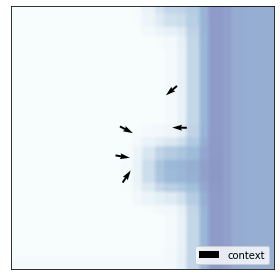

In [14]:
eloss, e_params = opt_generator_loss(context_np, env_np, loss_dataset.resolution, weight_psloss=0.0, weight_closs=0.0, weight_eloss=1.0)
plot_test_result(eloss, context_loss, mask_loss, env_loss, arrow_color='black')

In [15]:
ploss, ps_params = opt_generator_loss(context_np, env_np, loss_dataset.resolution, weight_psloss=1.0, weight_closs=0.0, weight_eloss=0.0)
plot_test_result(ploss, context_loss, mask_loss, env_loss, arrow_color="black", filename='ploss.svg')

In [16]:
closs, c_params = opt_generator_loss(context_np, env_np, loss_dataset.resolution, weight_psloss=0.0, weight_closs=1.0, weight_eloss=0.0)
plot_test_result(closs, context_loss, mask_loss, env_loss, arrow_color="black", filename="closs.svg")

In [17]:
combined, combined_params = opt_generator_loss(context_np, env_np, loss_dataset.resolution, weight_psloss=2.25, weight_closs=3.95, weight_eloss=0.05)
plot_test_result(combined, context_loss, mask_loss, env_loss, arrow_color='black', filename="combined.svg")